The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs. THe GPDs are reconstructed using the expansion in conformal partial waves and pertinent Mellin-Barnes integrals to resum their expansion in conformal moments.

In [1]:
# Import necessary libraries and set display options
import numpy as np
# import mpmath as mp
# import matplotlib.pyplot as plt
# from scipy.integrate import quad, trapezoid
# from joblib import Parallel, delayed
# from scipy.special import gamma, digamma

# import time
# import re
# import os

from mstw_pdf import (
    plot_uv_minus_dv_pdf, 
    plot_uv_plus_dv_plus_S_pdf,
    plot_gluon_pdf
)

from aac_pdf import(
    plot_polarized_uv_minus_dv_pdf,
    plot_polarized_uv_plus_dv_plus_S_pdf,
    plot_polarized_gluon_pdf
    )

from stringy_gpds import (
    plot_moment, 
    plot_moments_on_grid,
    plot_fourier_transform_moments,
    plot_moments_D_on_grid,
    evolve_conformal_moment,
    evolve_singlet_D,
    plot_mellin_barnes_gpd_integrand,  
    plot_non_singlet_quark_gpd, 
    plot_singlet_quark_gpd,
    plot_gluon_gpd,
    quark_helicity, spin_orbit_corelation,
    plot_fourier_transform_quark_helicity,
    plot_fourier_transform_spin_orbit_correlation
)
# Set display options
np.set_printoptions(linewidth=200)

Plots of conformal moments $\mathbb{G}_q(n,\eta,t)$ and their RGE evolution

Momentum space

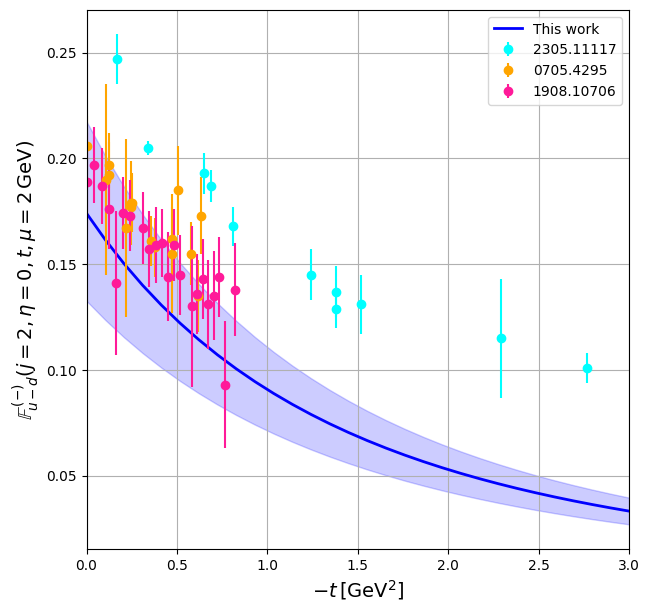

In [2]:
#NonSingletIsovector
y_label = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "A"
plot_moment(2,0,y_label,2,3,3,"quark",moment_type, moment_label,30)

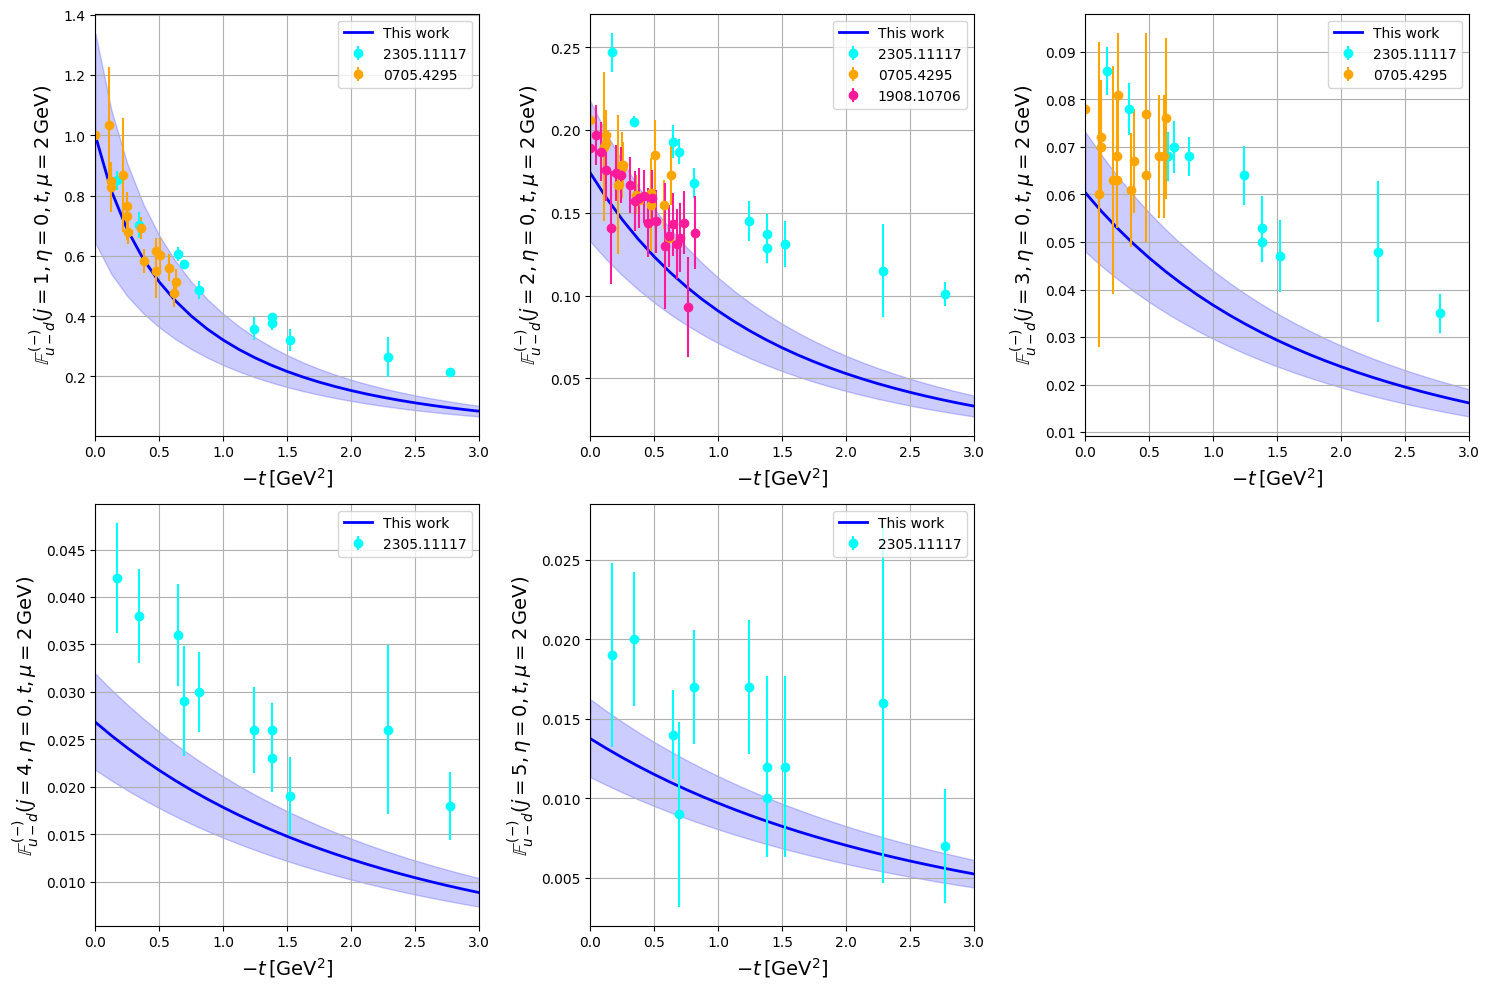

In [3]:
#NonSingletIsovector
y_label = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,25)

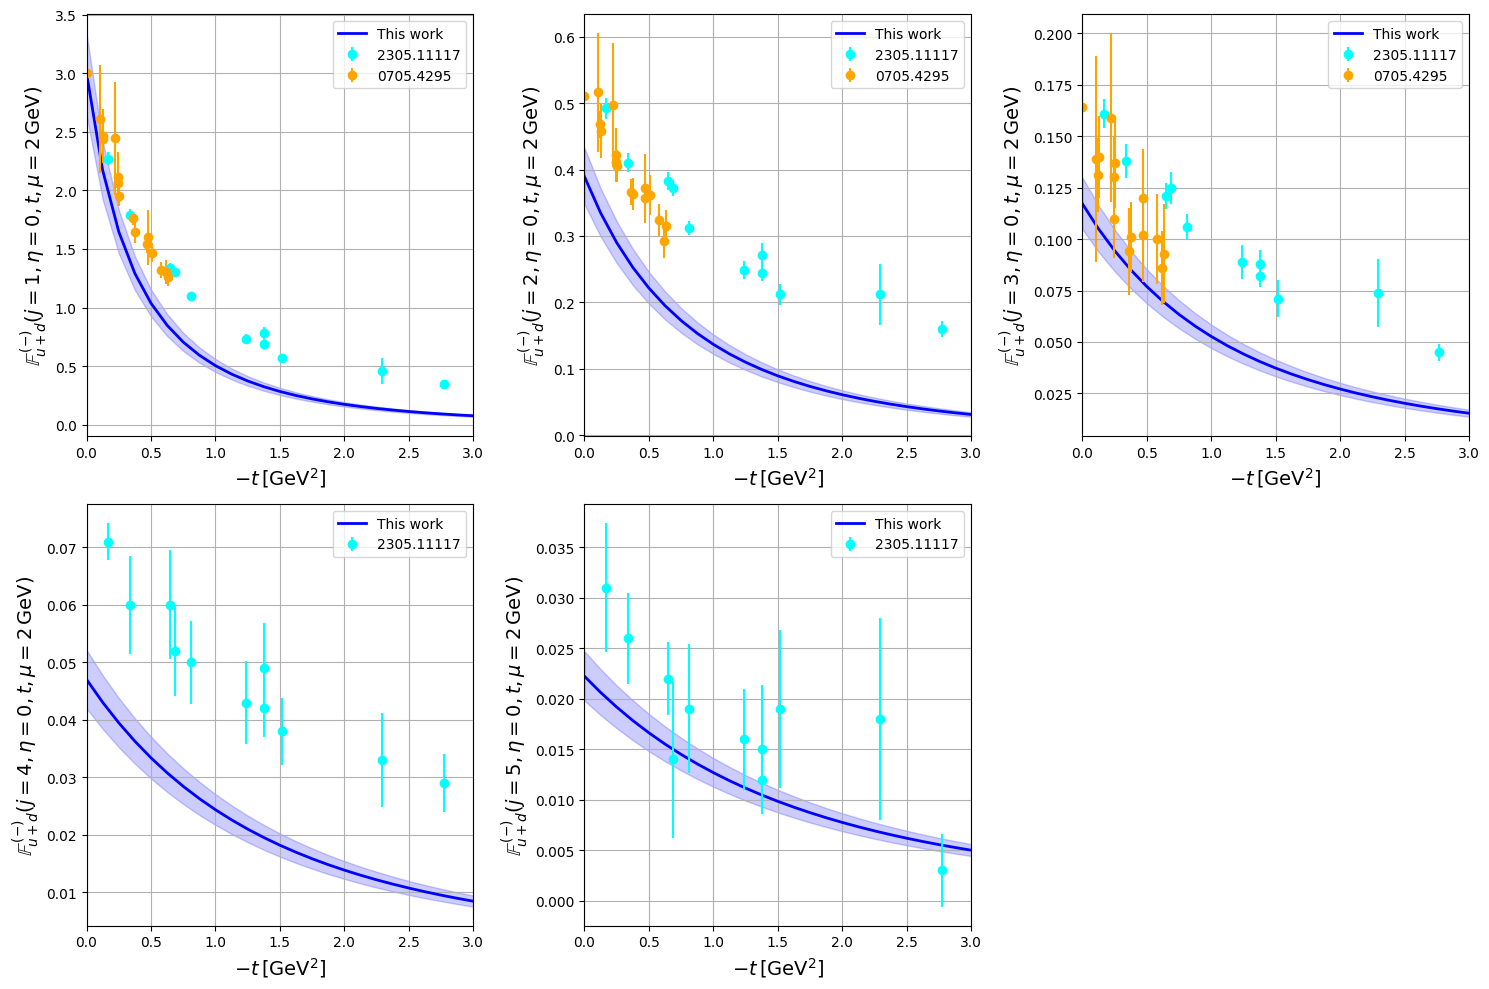

In [4]:
# NonSingletIsoscalar
y_label = "$\\mathbb{{F}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsoscalar"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,25)

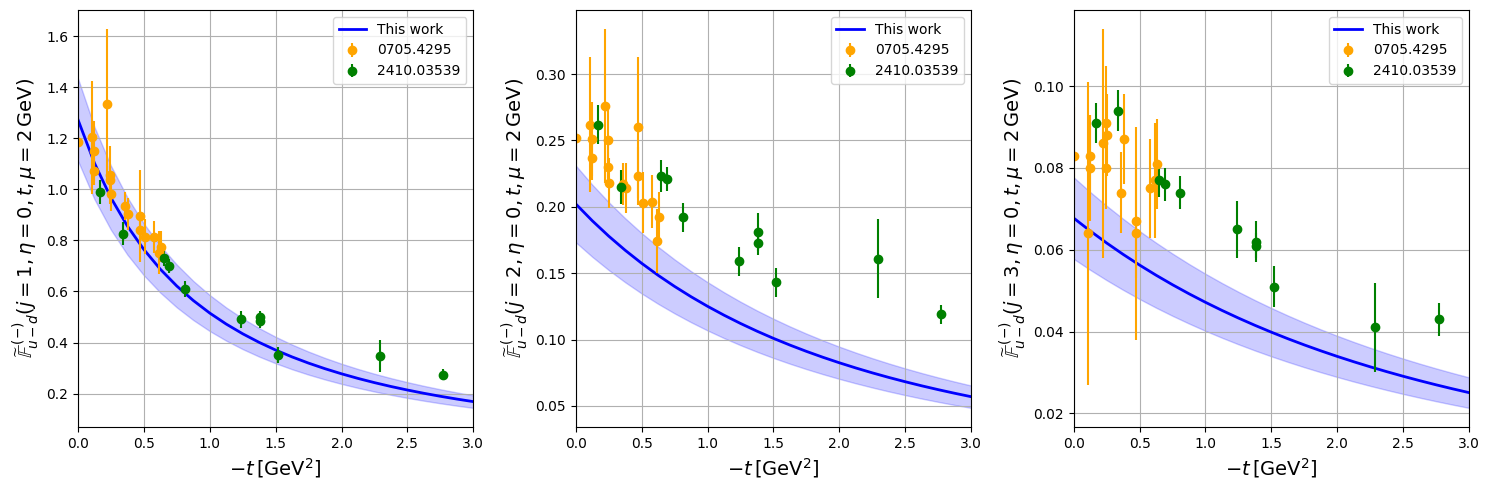

In [5]:
#NonSingletIsovector Axial
y_label = "$\\widetilde{\\mathbb{{F}}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,25)

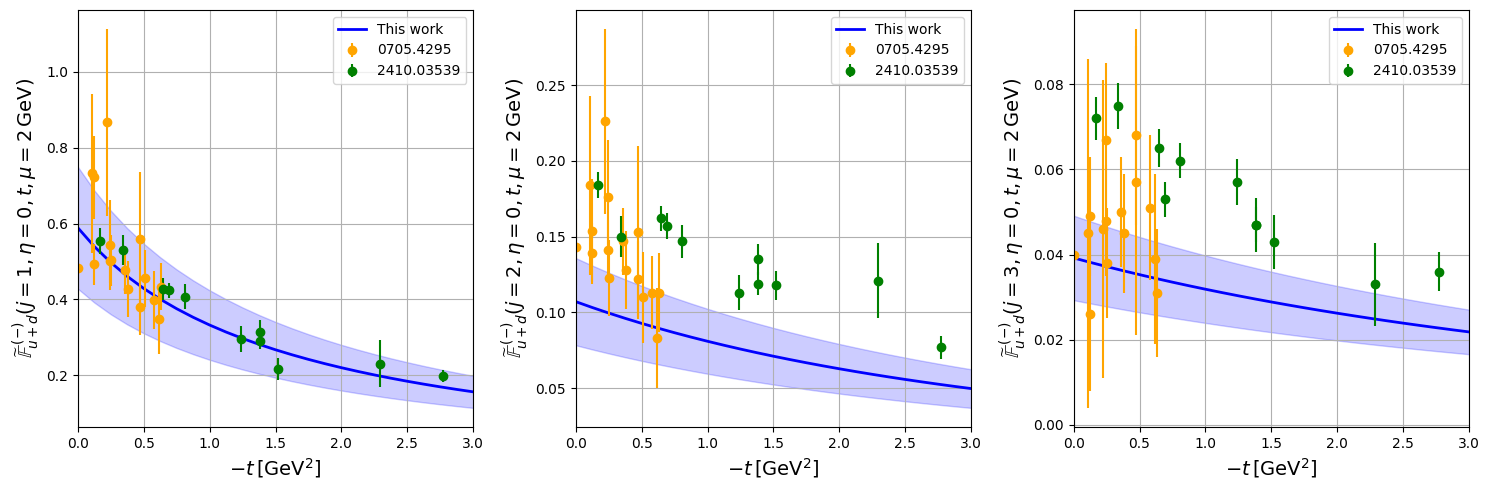

In [6]:
#NonSingletIsoscalar Axial
y_label = "$\\widetilde{\\mathbb{{F}}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsoscalar"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,25)

Impact parameter representation

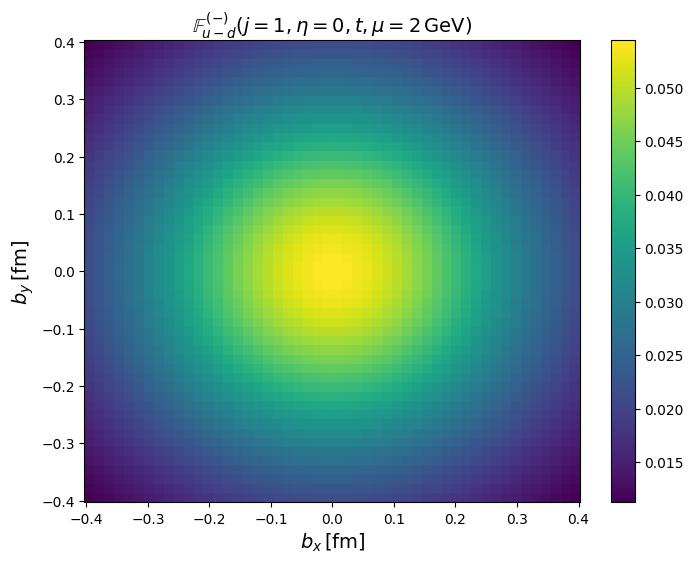

In [5]:
# Plot NonSingletIsovector in 2D impact parameter space
moment_type = "NonSingletIsovector"
moment_label = "A"
plot_title = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
plot_fourier_transform_moments(1,0,2,plot_title,moment_type=moment_type,moment_label=moment_label)

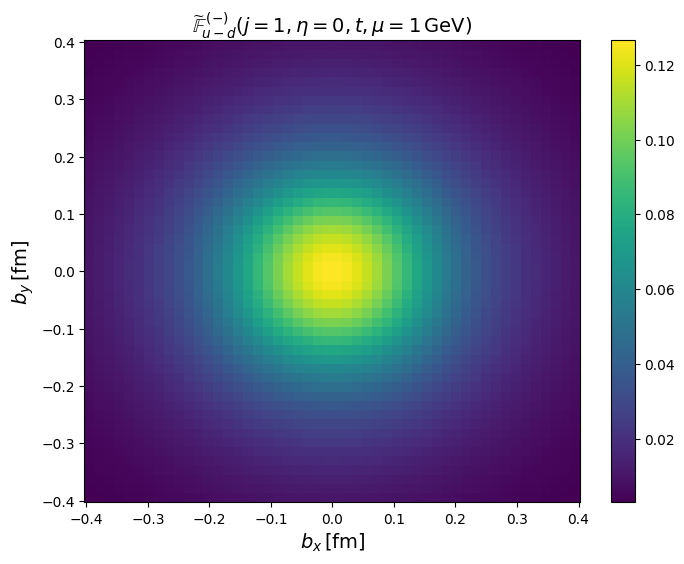

In [6]:
# Plot NonSingletIsovector in 2D impact parameter space
moment_type = "NonSingletIsoscalar"
moment_label = "Atilde"
plot_title = "$\\widetilde{\\mathbb{{F}}}_{{u-d}}^{{\,\,(-)}}$"
plot_fourier_transform_moments(1,0,1,plot_title,moment_type=moment_type,moment_label=moment_label)

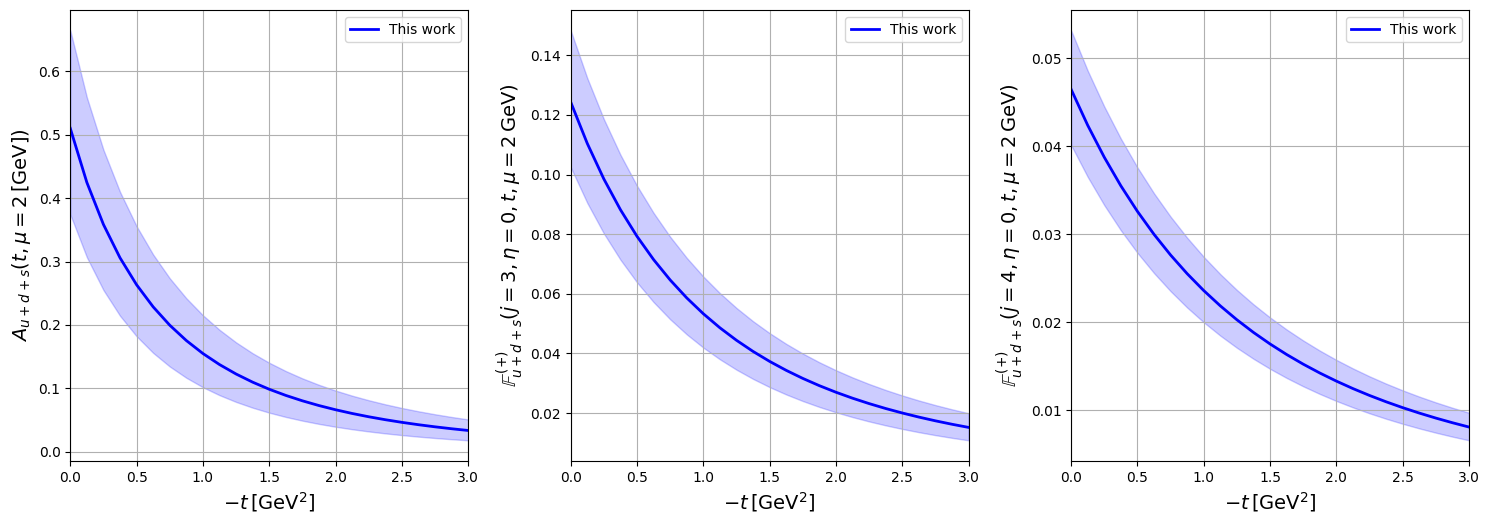

In [2]:
# Sea Quark Singlet
y_label = "$\\mathbb{{F}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "Singlet"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,25)

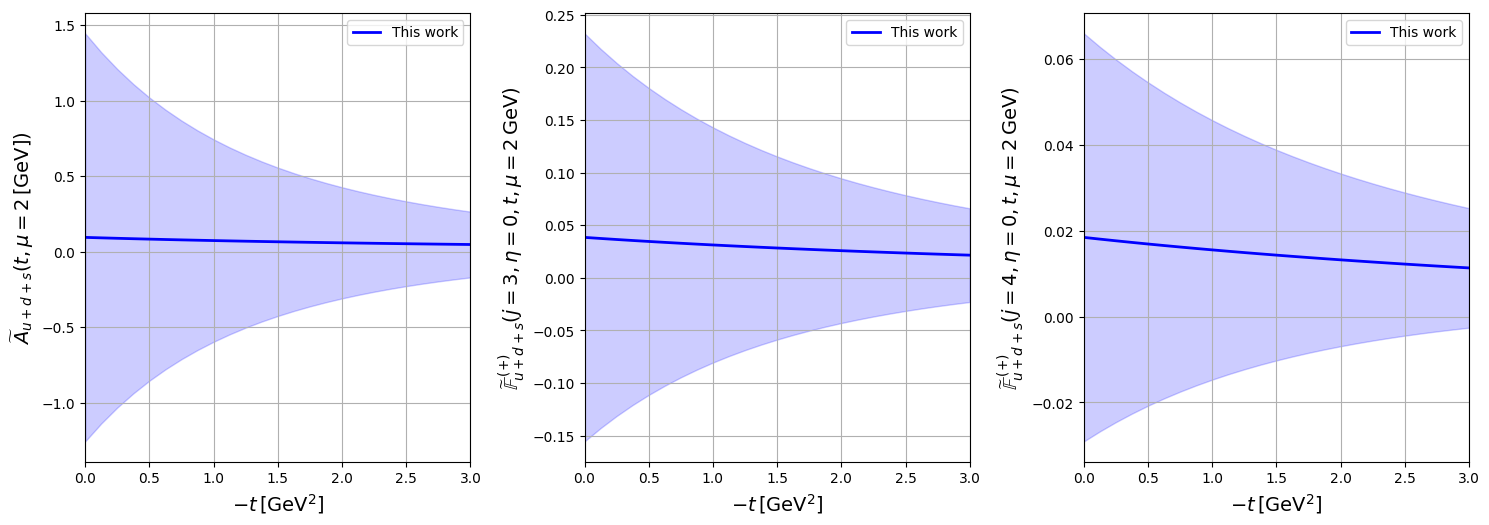

In [3]:
# Sea Quark Singlet
y_label = "$\\widetilde{\\mathbb{{F}}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "Singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,25)

In [2]:
# 0.510024649589122
# -1.30044714988575
# 0.50111263175031
# -2.57000756593034
print(evolve_conformal_moment(2,0,-1e-4,2,3,"quark","Singlet","A","central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"quark","A","central"))
print(evolve_conformal_moment(2,0,-1e-4,2,3,"gluon","Singlet","A","central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"gluon","A","central"))

0.5100029654252884
-1.29999956564934
0.501008173861975
-2.56999962157614


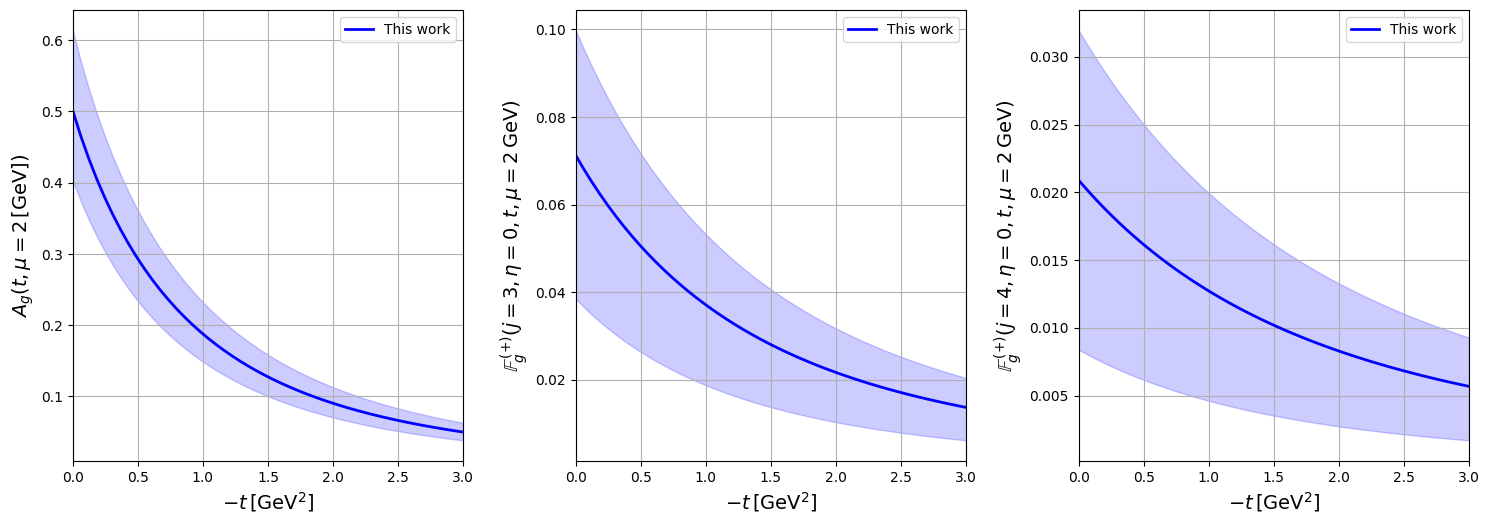

In [3]:
y_label = "$\\mathbb{{F}}_{{g}}^{{\,\,(+)}}$"
particle = "gluon"
moment_type = "Singlet"
moment_label = "A"
plot_moments_on_grid(0,y_label,3,3,particle,moment_type,moment_label)

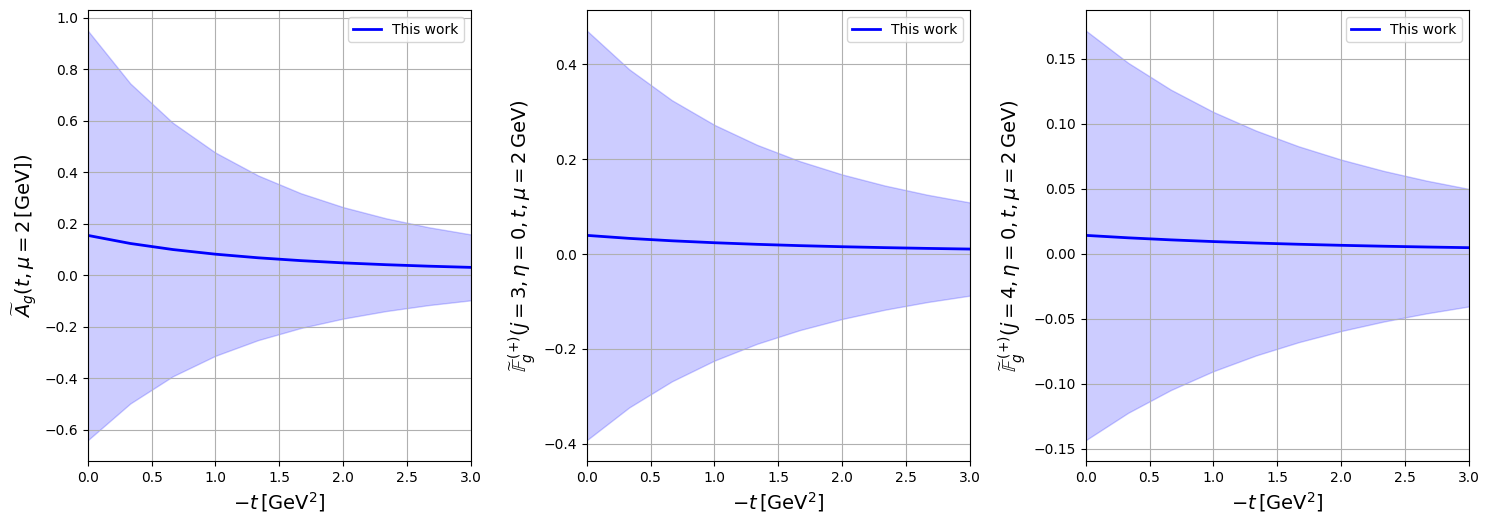

In [4]:
# Gluon Singlet
y_label = "$\\widetilde{\\mathbb{{F}}}_{{g}}^{{\,\,(+)}}$"
moment_type = "Singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"gluon",moment_type, moment_label,10)

Plots of GPDs through Mellin-Barnes Integral

In [3]:
from stringy_gpds import (
    mellin_barnes_gpd, 
    check_moment_type_label,
    check_particle_type
)
import time
import os
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
PLOT_PATH =  "/mnt/c/Users/flori/Documents/PostDoc/Plots/GPD/"


def plot_gpds(particle="quark",moment_type="NonSingletIsovector",moment_label="A",sampling=True, n_init=os.cpu_count(), n_points=50, x_0=-1, x_1=1, y_0 = -1e-2, y_1 = 3, error_bars=True, plot_legend = False):
    """
    Plot the real or imaginary part of the singlet quark GPD
    with dynamically adjusted x intervals, including error bars.
    The function supports both positive and negative values of parton x.

    Parameters:
    - sampling (True or False): Choose whether to plot using importance sampling  
    - n_init (int): Sampling size, default is available number of CPUs
    - n_points (int): Number of plot points
    - x_0 (float): lower bound on parton x
    - x_1 (float): upper bound on parton x
    - error_bars (bool): Compute error bars as well
    - plot_legend (bool): Show plot legend
    """
    check_particle_type(particle)
    check_moment_type_label(moment_type,moment_label)
    # Set plot parameters
    Nf, mu = 3,2
    
    eta_array = [0.0,1/3,0.1]
    t_array = [-1e-4,-0.69,-0.23]
    colors = ["purple","green","orange"]
    # eta_array = [0.0,0.1]
    # t_array = [-1e-4,-0.23]
    # colors = ["purple","orange"]

    if moment_type == "Singlet":
        x_0 = 1e-2

    def compute_result(x, eta,t,mu,error_type="central"):
        return mellin_barnes_gpd(x, eta, t, mu, Nf,particle,moment_type,moment_label, real_imag="real", error_type=error_type,n_jobs=1)
        # Test
        # if error_type == "central":
        #     norm = 1
        # elif error_type == "plus":
        #     norm = 1.1
        # elif error_type == "minus":
        #     norm =.9
        # return norm * (x + eta + t)

    for eta, t, color in zip(eta_array,t_array,colors):
        if sampling:
            x_values = np.linspace(x_0, x_1, n_init)

            # Measure time for sampling initial points
            start_time_sampling = time.time()
            results = Parallel(n_jobs=-1)(delayed(compute_result)(x,eta,t,mu) for x in x_values)
            end_time_sampling = time.time()

            # Compute differences and scale intervals
            diffs = np.abs(np.diff(results))
            scaled_intervals = diffs / np.sum(diffs)
            cumulative_intervals = np.cumsum(np.insert(scaled_intervals, 0, 0))

            # Output sampling time
            print(f"Time for initial sampling for parameters (eta,t) = ({eta,t}): {end_time_sampling - start_time_sampling:.6f} seconds")

        # Measure time for adaptive grid computation
        start_time_adaptive = time.time()
        if sampling:
            x_values = np.interp(np.linspace(x_0, x_1, n_points), cumulative_intervals, x_values)
        else:
            x_values = np.linspace(x_0, x_1, n_points)

        results = Parallel(n_jobs=-1)(delayed(compute_result)(x,eta,t,mu) for x in x_values)

        # Error bar computations
        if error_bars:
            results_plus = Parallel(n_jobs=-1)(delayed(compute_result)(x,eta,t,mu, error_type="plus") for x in x_values)
            results_minus = Parallel(n_jobs=-1)(delayed(compute_result)(x,eta,t,mu, error_type="minus") for x in x_values)
        else:
            results_plus = results
            results_minus = results
        end_time_adaptive = time.time()

        # Extract real and imaginary parts of results
        # x_values, unique_indices = np.unique(x_values, return_index=True)
        # data = np.real(results)[unique_indices]

        # # Compute real and imaginary error bars
        # errors_plus = abs(np.real(results_plus)[unique_indices] - data)
        # errors_minus = abs(data - np.real(results_minus)[unique_indices])

        # Output plot generation time
        print(f"Time for plot computation for parameters (eta,t) = ({eta,t}): {end_time_adaptive - start_time_adaptive:.6f} seconds")

        # if error_bars:
        #         plt.errorbar(
        #             x_values, data,
        #             yerr=(errors_minus, errors_plus),
        #             fmt='o', label=(f"$\\eta={eta:.2f}$"
        #                             f"$t={t:.2f} \\text{{ GeV}}^2$"),
        #             color=color, capsize=3
        #         )
        # else:
        #     plt.scatter(
        #             x_values, data,
        #             label=(f"$\\eta={eta:.2f}$"
        #                         f"$t={t:.2f} \\text{{ GeV}}^2$"),
        #             color=color
        #         )
        if error_bars:
            plt.plot(x_values, results,label=(f"$\\eta={eta:.2f}$, "
                    f"$t={t:.2f} \\text{{ GeV}}^2$"), color=color)
            plt.fill_between(x_values,results_minus,results_plus,color=color,alpha=.2)
        else:
            plt.plot(x_values, results,label=(f"$\\eta={eta:.2f}$, "
                    f"$t={t:.2f} \\text{{ GeV}}^2$"), color=color)
        # Add vertical lines to separate DGLAP from ERBL region
        plt.axvline(x=eta, linestyle='--', color = color)   
        plt.axvline(x=-eta, linestyle='--', color = color)

    plt.xlim(x_0, x_1)
    plt.ylim(y_0,y_1)
    plt.xlabel('x')
    if moment_type == "NonSingletIsovector" and moment_label == "A":
        ylabel = "$H_{u-d}(x,\eta,t;\mu)$"
    elif moment_type == "NonSingletIsoscalar" and moment_label == "A":
        ylabel = "$H_{u+d}(x,\eta,t;\mu)$"
    elif moment_type == "NonSingletIsovector" and moment_label == "Atilde":
        ylabel = r"$\widetilde{H}_{u-d}(x,\eta,t;\mu)$"
    elif moment_type == "NonSingletIsoscalar" and moment_label == "Atilde":
        ylabel = r"$\widetilde{H}_{u+d}(x,\eta,t;\mu)$"
    elif moment_type == "Singlet" and moment_label == "A":
        if particle == "quark":
            ylabel = "$H_{u+d+s}(x,\eta,t;\mu)$"
        else: 
            ylabel = "$H_{g}(x,\eta,t;\mu)$"
    elif moment_type == "Singlet" and moment_label == "Atilde":
        if particle == "quark":
            ylabel = r"$\widetilde{H}_{u+d+s}(x,\eta,t;\mu)$"
        else: 
            ylabel = r"$\widetilde{H}_{g}(x,\eta,t;\mu)$"
    plt.ylabel(ylabel, fontsize=14)
    if plot_legend:
        plt.legend()
    plt.grid(True)
    # Export
    FILE_PATH = PLOT_PATH + moment_type + particle + "GPD_" + moment_label +".pdf"
    plt.savefig(FILE_PATH,format="pdf",bbox_inches="tight")

    plt.show()

Time for initial sampling for parameters (eta,t) = ((0.0, 0.0)): 2.036035 seconds
Time for plot computation for parameters (eta,t) = ((0.0, 0.0)): 67.367429 seconds
Time for initial sampling for parameters (eta,t) = ((0.3333333333333333, -0.69)): 1.995177 seconds
Time for plot computation for parameters (eta,t) = ((0.3333333333333333, -0.69)): 176.024100 seconds
Time for initial sampling for parameters (eta,t) = ((0.1, -0.23)): 4.363895 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 190.746868 seconds


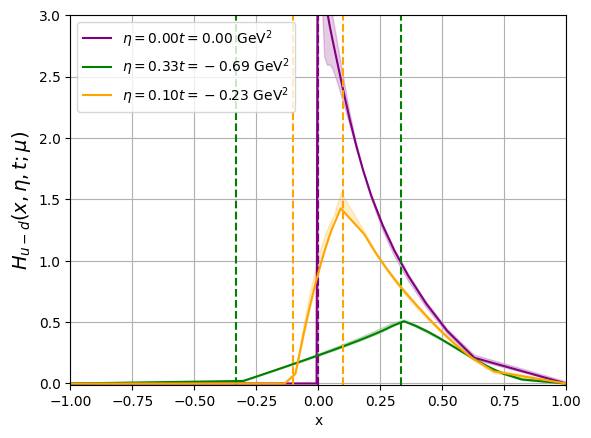

In [89]:
plot_gpds(particle="quark",moment_type="NonSingletIsovector",moment_label="A",plot_legend=True)

Time for initial sampling for parameters (eta,t) = ((0.0, -0.0001)): 3.489807 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.0001)): 57.377435 seconds
Time for initial sampling for parameters (eta,t) = ((0.3333333333333333, -0.69)): 1.841977 seconds
Time for plot computation for parameters (eta,t) = ((0.3333333333333333, -0.69)): 81.406176 seconds
Time for initial sampling for parameters (eta,t) = ((0.1, -0.23)): 3.995499 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 141.287270 seconds


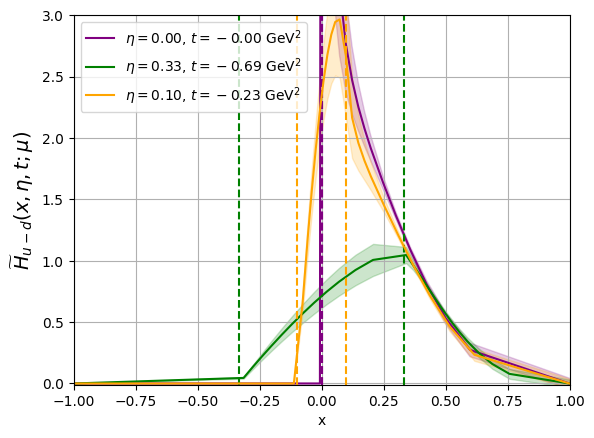

In [5]:
plot_gpds(particle="quark",moment_type="NonSingletIsovector",moment_label="Atilde",plot_legend=True)

Time for initial sampling for parameters (eta,t) = ((0.0, -0.0001)): 1.954210 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.0001)): 104.185565 seconds
Time for initial sampling for parameters (eta,t) = ((0.3333333333333333, -0.69)): 4.627006 seconds
Time for plot computation for parameters (eta,t) = ((0.3333333333333333, -0.69)): 99.389769 seconds
Time for initial sampling for parameters (eta,t) = ((0.1, -0.23)): 3.447680 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 135.023794 seconds


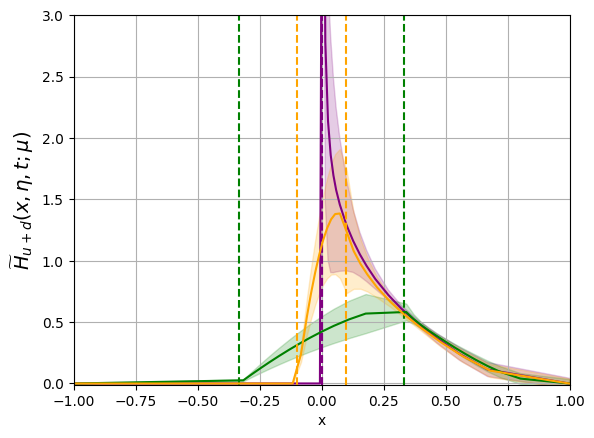

In [6]:
plot_gpds(particle="quark",moment_type="NonSingletIsoscalar",moment_label="Atilde")

Time for initial sampling for parameters (eta,t) = ((0.0, -0.0001)): 50.153862 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.0001)): 349.852387 seconds
Time for initial sampling for parameters (eta,t) = ((0.3333333333333333, -0.69)): 49.050852 seconds
Time for plot computation for parameters (eta,t) = ((0.3333333333333333, -0.69)): 174.383486 seconds
Time for initial sampling for parameters (eta,t) = ((0.1, -0.23)): 43.006591 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 234.976278 seconds


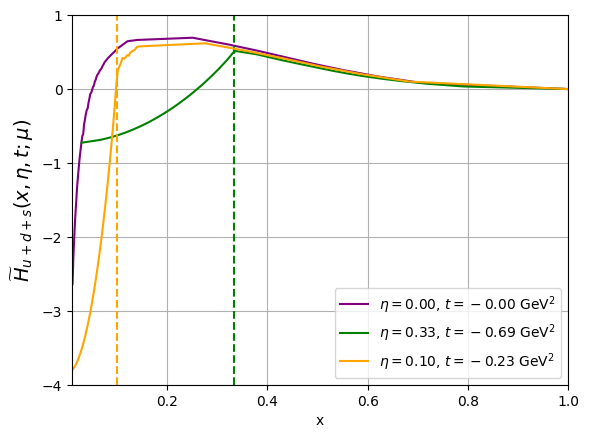

In [4]:
plot_gpds(particle="quark",moment_type="Singlet",moment_label="Atilde",error_bars=False,y_0=-4,y_1=1, plot_legend=True)

Time for initial sampling for parameters (eta,t) = ((0.0, -0.0001)): 28.792012 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.0001)): 107.053527 seconds
Time for initial sampling for parameters (eta,t) = ((0.3333333333333333, -0.69)): 24.132671 seconds
Time for plot computation for parameters (eta,t) = ((0.3333333333333333, -0.69)): 125.150192 seconds
Time for initial sampling for parameters (eta,t) = ((0.1, -0.23)): 17.734129 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 92.057140 seconds


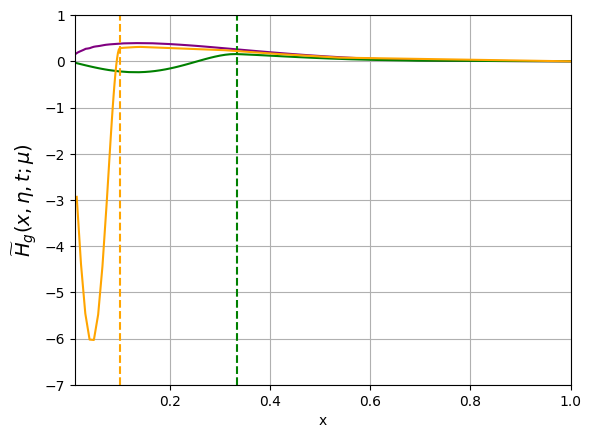

In [5]:
plot_gpds(particle="gluon",moment_type="Singlet",moment_label="Atilde",y_0=-7,y_1 = 1, error_bars=False)

In [6]:
spin_orbit_corelation(1)
spin_orbit_corelation(1,"NonSingletIsoscalar")
quark_helicity(1)
quark_helicity(1,"NonSingletIsoscalar")

NonSingletIsovector spin-orbit correlation: -0.376(+- 0.171) at 1 GeV
NonSingletIsoscalar spin-orbit correlation: -1.434(+- 0.171) at 1 GeV
NonSingletIsovector quark helicity: 0.637(\pm 0.081) at 1 GeV
NonSingletIsoscalar quark helicity: 0.294(\pm 0.080) at 1 GeV


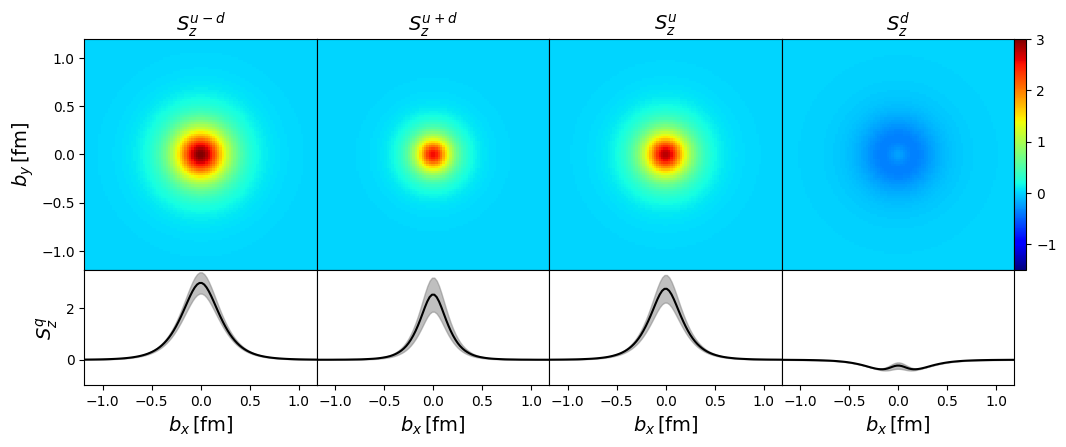

In [7]:
plot_fourier_transform_quark_helicity(0,1,moment_type="all",n_b=100)

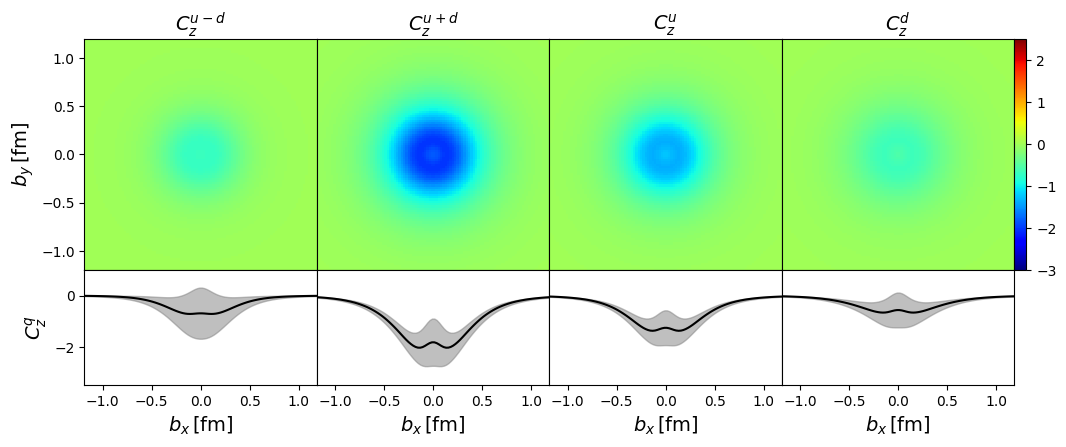

In [8]:
plot_fourier_transform_spin_orbit_correlation(0,1,moment_type="all",n_b=100,Delta_max=8)